In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Read Data
data = pd.read_csv('Data/glucose_data_1.csv')

# Convert Data
data['time'] = pd.to_datetime(data['time'])
#data = data.groupby('PtID').apply(lambda x: x.sort_values('DeviceDtTm'))
data = data.sort_values(['patient_id', 'time'])


# Normalize Data (Glucose)
scaler = MinMaxScaler(feature_range=(0, 1))
data['glucose_value'] = scaler.fit_transform(data['glucose_value'].values.reshape(-1, 1))

unique_pt_ids = data['patient_id'].unique()
print(unique_pt_ids)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]


In [2]:
# Search Data for Specific PtID
data_patient_2 = data.loc[data['patient_id'] == 10]
data_patient_2

,record_id,patient_id,time,diabetic,meal,activity,insulin_shot,glucose_value
145152,145153,10,2023-05-23 00:00:00,True,False,False,False,0.395829
145153,145154,10,2023-05-23 00:05:00,True,False,False,False,0.513159
145154,145155,10,2023-05-23 00:10:00,True,False,False,False,0.486132
145155,145156,10,2023-05-23 00:15:00,True,False,False,False,0.412003
145156,145157,10,2023-05-23 00:20:00,True,False,True,False,0.251046
...,...,...,...,...,...,...,...,...
161275,161276,10,2023-07-17 23:35:00,True,True,False,False,0.847202
161276,161277,10,2023-07-17 23:40:00,True,True,False,False,0.798539
161277,161278,10,2023-07-17 23:45:00,True,True,False,False,0.878201
161278,161279,10,2023-07-17 23:50:00,True,True,False,True,0.411932


In [3]:
# Filter data based on "diabetic" column
diabetic_true_ids = data[data['diabetic'] == True]['patient_id'].unique()
diabetic_false_ids = data[data['diabetic'] == False]['patient_id'].unique()

# Print patient IDs where "diabetic" is True
print("Patient IDs with diabetic=True:")
print(diabetic_true_ids)

# Print patient IDs where "diabetic" is False
print("Patient IDs with diabetic=False:")
print(diabetic_false_ids)

Patient IDs with diabetic=True:
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
Patient IDs with diabetic=False:
[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200]


In [4]:
time_count_by_patient = data.groupby('patient_id')['time'].count()
is_same_count = (time_count_by_patient.nunique() == 1)

if is_same_count:
    print("Alle patient_id haben die gleiche Anzahl von 'time'-Werten.")
else:
    print("Die patient_id haben unterschiedliche Anzahlen von 'time'-Werten.")


Alle patient_id haben die gleiche Anzahl von 'time'-Werten.


# Split Data into TRAIN / VALIDATE / TEST

In [5]:
np.random.shuffle(unique_pt_ids)

train_data = []
validation_data = []
test_data = []

# Split data for each patient
for patient_id in unique_pt_ids:
    patient_data = data[data['patient_id'] == patient_id]
    # Calculate split sizes
    train_size = int(len(patient_data) * 0.7)
    validation_size = int(len(patient_data) * 0.15)

    train_data.append(patient_data.iloc[:train_size])
    validation_data.append(patient_data.iloc[train_size:train_size+validation_size])
    test_data.append(patient_data.iloc[train_size+validation_size:])

train_data = pd.concat(train_data)
validation_data = pd.concat(validation_data)
test_data = pd.concat(test_data)


In [7]:
sequence_length = 5

def prepare_sequences(data):
    grouped = data.groupby('patient_id')

    sequences = []
    targets = []

    # Generate sequences for each patient
    for name, group in grouped:
        # Prepare sequences for each PtID
        relevant_values = group[['glucose_value', 'meal', 'activity', 'insulin_shot']].values
        for i in range(sequence_length, len(relevant_values)):
            sequences.append(relevant_values[i-sequence_length:i])
            targets.append(relevant_values[i, 0])

    sequences = np.array(sequences)
    targets = np.array(targets)

    # Reshape for LSTM input
    sequences = np.reshape(sequences, (sequences.shape[0], sequences.shape[1], -1))  # -1 for automatic dimension calculation

    return sequences, targets

train_sequences, train_targets = prepare_sequences(train_data)
validation_sequences, validation_targets = prepare_sequences(validation_data)
test_sequences, test_targets = prepare_sequences(test_data)


In [8]:
train_sequences = train_sequences.astype('float32')
train_targets = train_targets.astype('float32')
validation_sequences = validation_sequences.astype('float32')
validation_targets = validation_targets.astype('float32')


In [9]:
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 4)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
#
# model.summary()
# model.fit(train_sequences, train_targets, validation_data=(validation_sequences, validation_targets), epochs=5, verbose=1)

In [10]:
import os
import datetime
from keras.callbacks import TensorBoard


log_dir = os.path.join("Records", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 4)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

model.fit(train_sequences, train_targets, validation_data=(validation_sequences, validation_targets), epochs=5, verbose=1, callbacks=[tensorboard_callback])
#tensorboard --logdir Records

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
70525/70525 [==============================] - 192s 3ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 2/5
70525/70525 [==============================] - 170s 2ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 3/5
70525/70525 [==============================] - 176s 2ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 4/5
70525/70525 [==============================] - 170s 2ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 5/5
70525/70525 [=====

In [25]:
test_data['patient_id'].unique()

array([  3,   1,  32, 101, 100, 121, 194,  65,  26, 171, 176,  13, 154,
        75, 165,  68,  12, 148, 189,  47, 168, 180, 123,  92,  42,  57,
       105, 178,  48, 122,   6, 163,  67,  51, 110, 169,   7,  79, 108,
        14,  82, 137,  93, 161,  53, 135, 140,   8, 116,  11,   5,  96,
       102, 175, 149,  23,  17,   9, 174,  85,  15, 120,  72, 185,  54,
       117,  73, 133,  87,  20, 198,   2, 184, 130, 143, 181,  35,  49,
        98, 145,  77,  33,  10, 164,  34, 196,  80, 195,  99, 147, 177,
        31,  40,  69, 106,  56,  90,  46,  44,  78,  41, 107,  28, 193,
        81, 183, 104, 170,  30, 118,  22,  86,  66, 150, 173, 179, 191,
       182,  43,  24, 200, 157,  29, 151,  59,  63, 126, 114,  60, 156,
       132,  45, 119,  74, 103, 152, 125, 197, 192,  37,  70, 134,  52,
        38, 109,  95,  94, 158, 190,  61, 166,  19, 112, 146, 144,  25,
       160, 115, 111,  76,  27, 167,  89,  18, 153,  55, 138, 187, 136,
       128,  62,  16, 139,   4, 188,  50, 142,  58,  36, 199, 13

76/76 [==============================] - 0s 2ms/step


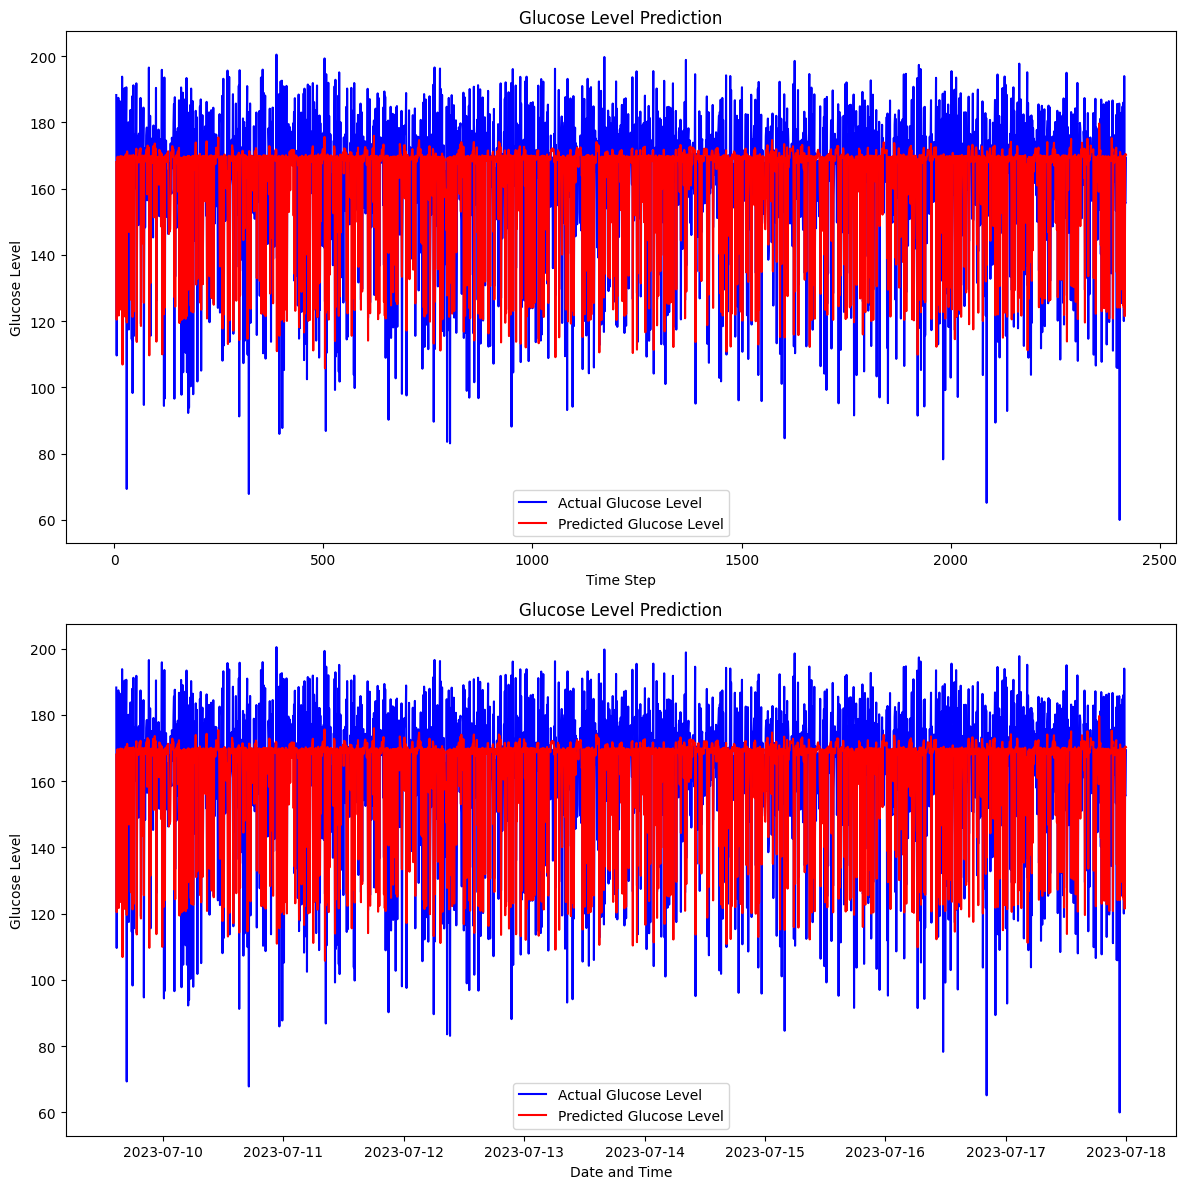

In [29]:
import matplotlib.pyplot as plt

patient_id = 32

# Ensure to use data from the test set
patient_data = test_data[test_data['patient_id'] == patient_id].sort_values('time')

glucose_values = patient_data['glucose_value'].values
features = patient_data[['glucose_value', 'meal', 'activity', 'insulin_shot']].values
patient_sequences = []
for i in range(sequence_length, len(features)):
    patient_sequences.append(features[i-sequence_length:i])

patient_sequences = np.array(patient_sequences, dtype=np.float32)
patient_sequences = np.reshape(patient_sequences, (patient_sequences.shape[0], patient_sequences.shape[1], 4))
predictions = model.predict(patient_sequences)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
actual_values = scaler.inverse_transform(glucose_values[sequence_length:].reshape(-1, 1))


fig, axs = plt.subplots(2, figsize=(12,12))

axs[0].plot(range(sequence_length, len(glucose_values)), actual_values, color='blue', label='Actual Glucose Level')
axs[0].plot(range(sequence_length, len(glucose_values)), predictions, color='red', label='Predicted Glucose Level')
axs[0].set_title('Glucose Level Prediction')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Glucose Level')
axs[0].legend()

patient_data['time'] = pd.to_datetime(patient_data['time'])
time_values = patient_data['time'].values[sequence_length:]
axs[1].plot(time_values, actual_values, color='blue', label='Actual Glucose Level')
axs[1].plot(time_values, predictions, color='red', label='Predicted Glucose Level')
axs[1].set_title('Glucose Level Prediction')
axs[1].set_xlabel('Date and Time')
axs[1].set_ylabel('Glucose Level')
axs[1].legend()

plt.tight_layout()
plt.show()


18/18 [==============================] - 0s 1ms/step


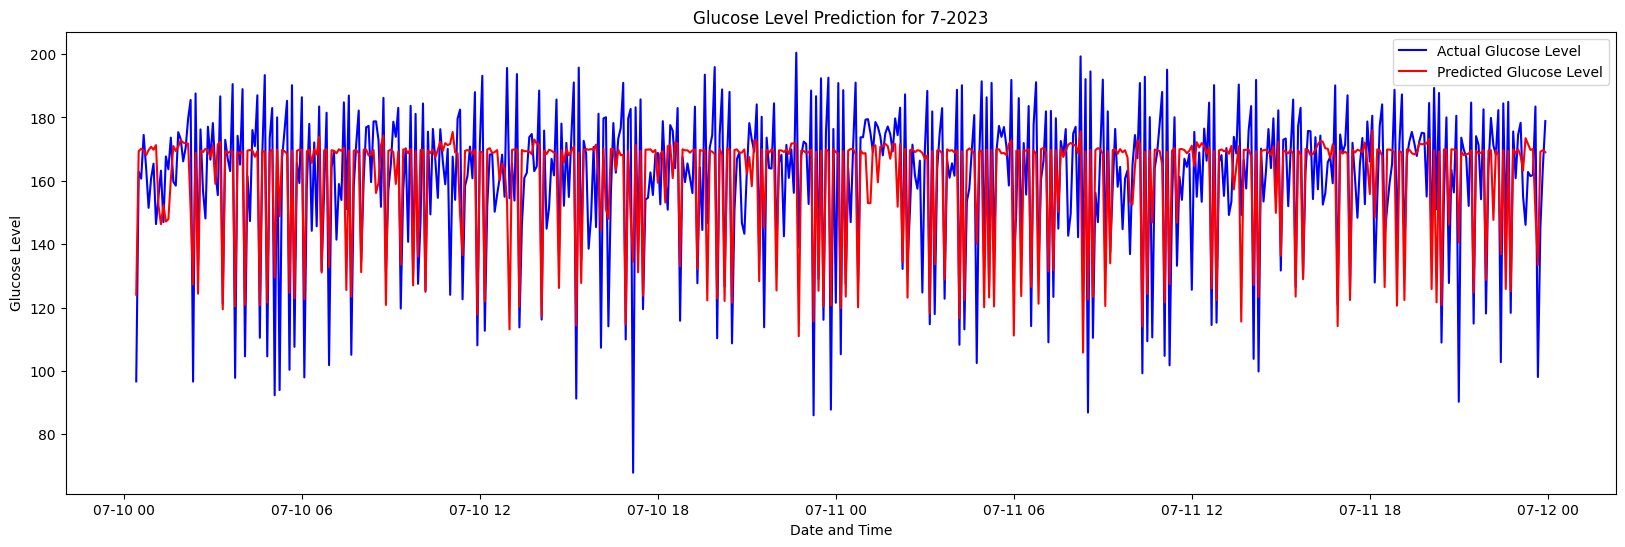

In [34]:
import matplotlib.pyplot as plt
import numpy as np

year = 2023
month = 7
start_day = 10
end_day = 11
patient_id = 32

patient_data_filtered = test_data.loc[(test_data['patient_id'] == patient_id) &
                                      (test_data['time'].dt.year == year) &
                                      (test_data['time'].dt.month == month) &
                                      (test_data['time'].dt.day >= start_day) &
                                      (test_data['time'].dt.day <= end_day)].copy()

for col in ['glucose_value', 'meal', 'activity', 'insulin_shot']:
    patient_data_filtered[col] = patient_data_filtered[col].astype(np.float32)

time_values_filtered = patient_data_filtered['time'].values
glucose_values_filtered = patient_data_filtered['glucose_value'].values

# Include all necessary features in the sequences
filtered_sequences = []
features = patient_data_filtered[['glucose_value', 'meal', 'activity', 'insulin_shot']].values
for i in range(sequence_length, len(features)):
    filtered_sequences.append(features[i-sequence_length:i])

filtered_sequences = np.array(filtered_sequences)
filtered_sequences = np.reshape(filtered_sequences, (filtered_sequences.shape[0], filtered_sequences.shape[1], 4))  # Change 1 to 4 as there are 4 features
predictions_filtered = model.predict(filtered_sequences)

actual_values_filtered = scaler.inverse_transform(glucose_values_filtered[sequence_length:].reshape(-1, 1))
predictions_filtered = scaler.inverse_transform(predictions_filtered.reshape(-1, 1))

plt.figure(figsize=(20,6))
plt.plot(time_values_filtered[sequence_length:], actual_values_filtered, color='blue', label='Actual Glucose Level')
plt.plot(time_values_filtered[sequence_length:], predictions_filtered, color='red', label='Predicted Glucose Level')
plt.title('Glucose Level Prediction for {}-{}'.format(month, year))
plt.xlabel('Date and Time')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()
